# Pedestrian Crash Risk Preprocessing Script

**Description**  
This notebook prepares Victorian road crash data for machine learning classification of pedestrian crash risk levels. It filters relevant data, engineers features, aggregates statistics by location, and produces visual insights.

**Dataset**  
Victorian Road Crash Data (VicRoads)  
<https://opendata.transport.vic.gov.au/dataset/bb77800e-1857-4edc-bf9e-e188437a1c8e/resource/5df1f373-0c90-48f5-80e1-7b2a35507134/download/victorian_road_crash_data.csv>

---

## Project Overview
We are building a classification model to predict the pedestrian crash risk level (`risk_category`) for each Melbourne location using road environment and urban context features.

**Target (`y`)**
- Low (1) – 1 crash
- Medium (2) – 2 crashes
- High (3) – 3 or more crashes

**Final Features (`X`)**
- `is_intersection`
- `SPEED_ZONE_60 km/hr`
- `SPEED_ZONE_40 km/hr`
- `LIGHT_CONDITION_Dark Street lights on`
- `ROAD_GEOMETRY_Multiple intersection`
- `DEG_URBAN_NAME_MELBOURNE_CBD`
- `DEG_URBAN_NAME_MELB_URBAN`
- `DTP_REGION_INNER METRO`

Notes:  
- Latitude and Longitude are retained for mapping only and are not used as model inputs.  
- Outcome-related variables not knowable pre-crash are excluded: `SERIOUSINJURY`, `INJ_OR_FATAL`, `vulnerable_total`.  
- Features with an absolute correlation to `risk_category` of less than 0.05 are excluded.

---

## Purpose of Prediction
Current risk categories are derived from past crash counts, which only describe known locations. The model aims to:
- Evaluate new or modified crossings.
- Flag locations with few or no crashes but similar conditions to high-risk sites.
- Generalise risk predictions to environments with similar characteristics.

---

## Data Decision
An initial merge of Pedestrian Counting, Landmarks, and VicRoads Crash data produced only ~140 rows due to limited overlap. For a more reliable baseline, this notebook focuses on VicRoads crash data.

---

## Status (This Notebook)
- Data preprocessing complete (cleaning, feature engineering, encoding).
- Exploratory Data Analysis completed (distributions, correlations, spatial checks).
- Feature selection applied based on domain rules and correlation thresholds.

---

## Next Steps
- Train classification models
- Evaluate performance (macro-F1, confusion matrix).
- Produce risk rankings and heatmaps for planners.


## STEP 1: Load crash dataset and inspect for missing values
Purpose: Ensure data integrity before filtering or feature engineering


In [ ]:
import pandas as pd
df = pd.read_csv("/content/victorian_road_crash_data.csv")
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184606 entries, 0 to 184605
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ACCIDENT_NO             184606 non-null  object 
 1   ACCIDENT_DATE           184606 non-null  object 
 2   ACCIDENT_TIME           184606 non-null  object 
 3   ACCIDENT_TYPE           184606 non-null  object 
 4   DAY_OF_WEEK             184606 non-null  object 
 5   DCA_CODE                184606 non-null  int64  
 6   DCA_CODE_DESCRIPTION    184606 non-null  object 
 7   LIGHT_CONDITION         184606 non-null  object 
 8   POLICE_ATTEND           184606 non-null  object 
 9   ROAD_GEOMETRY           184606 non-null  object 
 10  SEVERITY                184606 non-null  object 
 11  SPEED_ZONE              184606 non-null  object 
 12  RUN_OFFROAD             184606 non-null  object 
 13  ROAD_NAME               184362 non-null  object 
 14  ROAD_TYPE           

,0
ACCIDENT_NO,0
ACCIDENT_DATE,0
ACCIDENT_TIME,0
ACCIDENT_TYPE,0
DAY_OF_WEEK,0
DCA_CODE,0
DCA_CODE_DESCRIPTION,0
LIGHT_CONDITION,0
POLICE_ATTEND,0
ROAD_GEOMETRY,0


## STEP 2: Filter to pedestrian-involved crashes
Logic: Keep only "Struck Pedestrian" accident type

In [ ]:
# Example: Filter by pedestrian-involved accidents
df = df[df['ACCIDENT_TYPE'] == "Struck Pedestrian"]
df

,ACCIDENT_NO,ACCIDENT_DATE,ACCIDENT_TIME,ACCIDENT_TYPE,DAY_OF_WEEK,DCA_CODE,DCA_CODE_DESCRIPTION,LIGHT_CONDITION,POLICE_ATTEND,ROAD_GEOMETRY,...,NO_OF_VEHICLES,HEAVYVEHICLE,PASSENGERVEHICLE,MOTORCYCLE,PT_VEHICLE,DEG_URBAN_NAME,SRNS,RMA,DIVIDED,STAT_DIV_NAME
6,T20150009796,9/05/2015,18:02:00,Struck Pedestrian,Saturday,102,FAR SIDE. PED HIT BY VEHICLE FROM THE LEFT,Dusk/Dawn,Yes,Cross intersection,...,1.0,0.0,0.0,1.0,0.0,MELBOURNE_CBD,NaN,Local Road,Undivided,Metro
8,T20160000309,4/01/2016,17:50:00,Struck Pedestrian,Monday,100,PED NEAR SIDE. PED HIT BY VEHICLE FROM THE RIGHT.,Day,Yes,Cross intersection,...,1.0,0.0,1.0,0.0,0.0,MELBOURNE_CBD,NaN,Arterial Other,Divided,Metro
28,T20240018569,22/07/2024,16:14:00,Struck Pedestrian,Monday,102,FAR SIDE. PED HIT BY VEHICLE FROM THE LEFT,Day,Yes,Not at intersection,...,1.0,0.0,1.0,0.0,0.0,MELB_URBAN,NaN,Local Road,Undivided,Metro
37,T20180000465,9/01/2018,7:02:00,Struck Pedestrian,Tuesday,100,PED NEAR SIDE. PED HIT BY VEHICLE FROM THE RIGHT.,Day,Yes,Not at intersection,...,1.0,0.0,1.0,0.0,0.0,MELB_URBAN,NaN,Arterial Highway,Undivided,Metro
61,T20140004479,4/03/2014,5:45:00,Struck Pedestrian,Tuesday,102,FAR SIDE. PED HIT BY VEHICLE FROM THE LEFT,Dusk/Dawn,Yes,Not at intersection,...,1.0,0.0,0.0,1.0,0.0,MELB_URBAN,NaN,Local Road,Divided,Metro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184575,T20230024141,16/10/2023,15:00:00,Struck Pedestrian,Monday,100,PED NEAR SIDE. PED HIT BY VEHICLE FROM THE RIGHT.,Day,No,Cross intersection,...,1.0,0.0,1.0,0.0,0.0,MELB_URBAN,NaN,Arterial Highway,Undivided,Metro
184586,T20160004785,10/01/2016,00:00.0,Struck Pedestrian,Sunday,107,PED ON FOOTHPATH STRUCK BY VEHENTERING/LEAVING...,Day,Yes,Not at intersection,...,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
184590,T20120022939,7/10/2012,25:00.0,Struck Pedestrian,Sunday,104,PED WALKING WITH TRAFFIC,Dark No street lights,Yes,Cross intersection,...,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
184597,T20190010646,6/03/2019,00:00.0,Struck Pedestrian,Wednesday,109,ANY MANOEUVRE INVOLVING PED NOT INCLUDED IN DC...,Unk.,No,Unknown,...,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


## STEP 3: Group by location & assign risk_category (y)
Logic:

   1 crash  -> 1 (Low)

   2 crashes -> 2 (Medium)
   
   3+       -> 3 (High)

In [ ]:
# Count number of crashes per location
crash_counts = df.groupby(['LATITUDE', 'LONGITUDE']).size().reset_index(name='crash_count')

# Categorize risk
def categorize_risk(n):
    if n == 1:
        return 1  # Low Risk
    elif n == 2:
        return 2  # Medium Risk
    else:
        return 3  # High Risk

crash_counts['risk_category'] = crash_counts['crash_count'].apply(categorize_risk)

# Merge risk labels back to original dataframe
df = df.merge(crash_counts[['LATITUDE', 'LONGITUDE', 'risk_category']], on=['LATITUDE', 'LONGITUDE'], how='left')


## STEP 4: Feature Engineering at row-level (prior to location aggregation)
 - ACCIDENT_HOUR: hour-of-day signal
 - is_intersection: intersections are known pedestrian risk points
 - vulnerable_total: crashes involving children/seniors

In [ ]:
import numpy as np
df['ACCIDENT_HOUR'] = df['ACCIDENT_TIME'].str.split(':').str[0].astype(int)

In [ ]:
df['is_intersection'] = df['ROAD_GEOMETRY'].isin(['T intersection', 'Cross intersection', 'Multiple intersection']).astype(int)


In [ ]:
vulnerable_cols = ['OLD_PED_65_AND_OVER', 'PED_CYCLIST_5_12', 'PED_CYCLIST_13_18']
df['vulnerable_total'] = df[vulnerable_cols].sum(axis=1)


## STEP 5: Aggregate features by location (X candidates)
 For categorical columns, take the mode; for numeric, use mean/sum as appropriate.

In [ ]:
features_df = df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    'ACCIDENT_HOUR': 'mean',
    'DAY_OF_WEEK': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'SPEED_ZONE': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'LIGHT_CONDITION': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'ROAD_GEOMETRY': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'is_intersection': 'max',
    'NO_OF_VEHICLES': 'mean',
    'INJ_OR_FATAL': 'sum',
    'FATALITY': 'sum',
    'SERIOUSINJURY': 'sum',
    'vulnerable_total': 'sum',
    'DEG_URBAN_NAME': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'DTP_REGION': lambda x: x.mode().iloc[0] if not x.mode().empty else None
}).reset_index()


In [ ]:
# Attach risk label per location
features_df = features_df.merge(crash_counts[['LATITUDE', 'LONGITUDE', 'risk_category']], on=['LATITUDE', 'LONGITUDE'], how='left')


In [ ]:
# Basic cleanup
features_df = features_df.dropna()


In [ ]:
features_df.drop_duplicates(inplace=True)

## STEP 6: Encode categoricals (one-hot) & build (X, y) and quick EDA
Note: Lat/Long retained for mapping but excluded from training features.

In [ ]:
X = pd.get_dummies(features_df.drop(columns=['risk_category']), drop_first=True)
y = features_df['risk_category']


In [ ]:
X

,LATITUDE,LONGITUDE,ACCIDENT_HOUR,is_intersection,NO_OF_VEHICLES,INJ_OR_FATAL,FATALITY,SERIOUSINJURY,vulnerable_total,DAY_OF_WEEK_Monday,...,DEG_URBAN_NAME_RURAL_VICTORIA,DEG_URBAN_NAME_SMALL_CITIES,DEG_URBAN_NAME_SMALL_TOWNS,DEG_URBAN_NAME_TOWNS,DTP_REGION_GIPPSLAND,DTP_REGION_GRAMPIANS,DTP_REGION_GREATER METRO,DTP_REGION_HUME,DTP_REGION_INNER METRO,DTP_REGION_LODDON MALLEE
0,-38.830520,143.51971,16.0,0,1.0,1,0,0,0,False,...,True,False,False,False,False,False,False,False,False,False
1,-38.759290,143.66917,8.0,1,1.0,1,0,0,0,False,...,False,False,False,True,False,False,False,False,False,False
2,-38.757980,143.66852,13.0,0,1.0,1,0,1,0,False,...,False,False,False,True,False,False,False,False,False,False
3,-38.757782,143.67001,12.0,0,1.0,1,0,0,0,False,...,False,False,False,True,False,False,False,False,False,False
4,-38.757027,143.66945,13.0,1,1.0,1,0,0,0,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12861,-34.179200,142.14148,11.0,0,1.0,2,0,0,0,False,...,False,True,False,False,False,False,False,False,False,True
12862,-34.177643,142.10408,20.0,0,1.0,1,0,0,0,True,...,True,False,False,False,False,False,False,False,False,True
12863,-34.167930,142.06184,18.0,0,1.0,1,0,1,1,False,...,False,False,False,True,False,False,False,False,False,True
12864,-34.167927,142.06378,17.0,0,1.0,1,0,0,0,False,...,False,False,False,True,False,False,False,False,False,True


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12760 entries, 0 to 12865
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   LATITUDE                                    12760 non-null  float64
 1   LONGITUDE                                   12760 non-null  float64
 2   ACCIDENT_HOUR                               12760 non-null  float64
 3   is_intersection                             12760 non-null  int64  
 4   NO_OF_VEHICLES                              12760 non-null  float64
 5   INJ_OR_FATAL                                12760 non-null  int64  
 6   FATALITY                                    12760 non-null  int64  
 7   SERIOUSINJURY                               12760 non-null  int64  
 8   vulnerable_total                            12760 non-null  int64  
 9   DAY_OF_WEEK_Monday                          12760 non-null  bool   
 10  DAY_OF_WEEK_Sat

In [ ]:
X.describe()

,LATITUDE,LONGITUDE,ACCIDENT_HOUR,is_intersection,NO_OF_VEHICLES,INJ_OR_FATAL,FATALITY,SERIOUSINJURY,vulnerable_total
count,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000
mean,-37.758566,144.953779,13.521885,0.407367,1.048177,1.299687,0.036677,0.542085,0.447649
std,0.490961,0.633824,5.039217,0.491363,0.238575,0.963964,0.194129,0.679056,0.600378
min,-38.830520,141.015800,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,-37.920131,144.897325,10.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,-37.819940,144.997170,14.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,-37.744449,145.130740,17.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,-34.134315,149.757460,23.000000,1.000000,5.000000,14.000000,5.000000,8.000000,6.000000


In [ ]:
print("Dataset shape:", features_df.shape)
features_df.describe(include='all')
features_df['risk_category'].value_counts()


Dataset shape: (12760, 16)


,count
risk_category,
1,11670
2,576
3,514


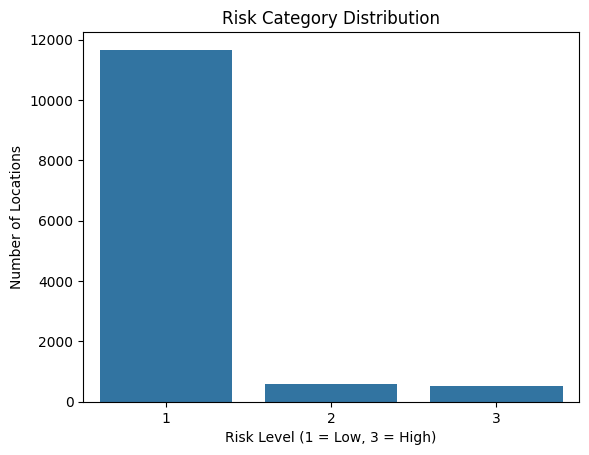

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=features_df, x='risk_category')
plt.title("Risk Category Distribution")
plt.xlabel("Risk Level (1 = Low, 3 = High)")
plt.ylabel("Number of Locations")
plt.show()


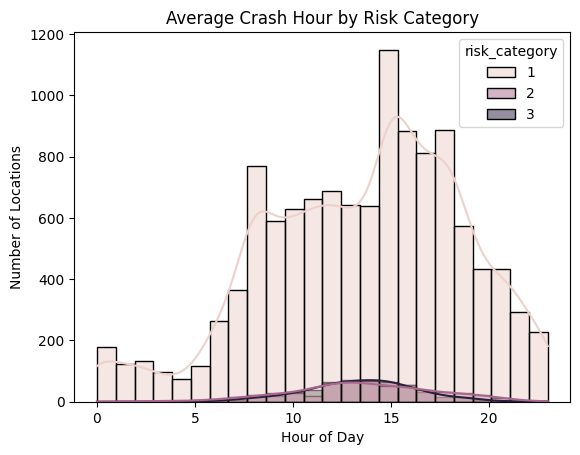

In [ ]:
sns.histplot(data=features_df, x='ACCIDENT_HOUR', hue='risk_category', kde=True, bins=24)
plt.title("Average Crash Hour by Risk Category")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Locations")
plt.show()


Most pedestrian crashes occur between 7 AM and 8 PM, with high-risk locations peaking between 12 PM and 6 PM. This aligns with busy pedestrian periods like lunch, school dismissal, and afternoon commuting. Crashes during late-night hours are rare across all risk levels.

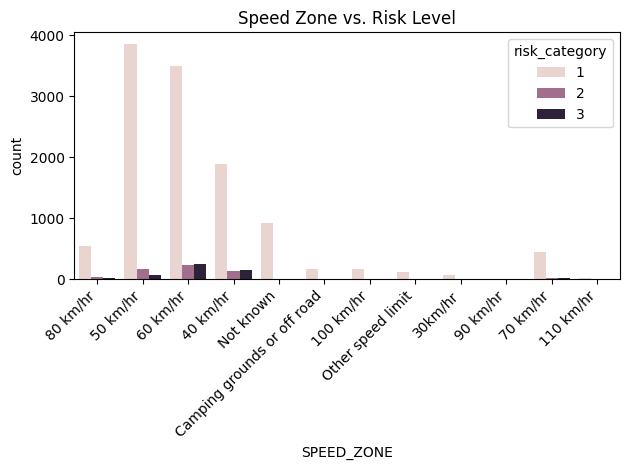

In [ ]:
sns.countplot(data=features_df, x='SPEED_ZONE', hue='risk_category')
plt.title("Speed Zone vs. Risk Level")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Most pedestrian crashes occur in 50 km/h and 60 km/h zones, reflecting common urban speed limits.
However, high-risk crashes (Risk Category 3) are more concentrated in 60 km/h and 40 km/h zones, suggesting elevated pedestrian danger in faster or more congested urban areas. Crashes in high-speed zones (70+ km/h) are rare but may be more severe when they occur.

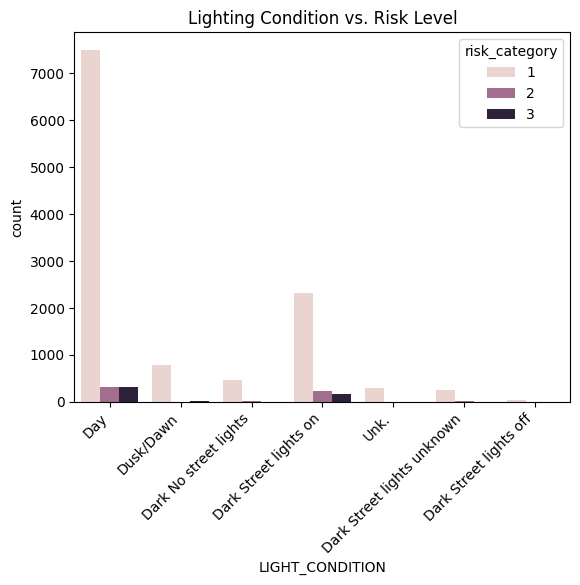

In [ ]:
sns.countplot(data=features_df, x='LIGHT_CONDITION', hue='risk_category')
plt.title("Lighting Condition vs. Risk Level")
plt.xticks(rotation=45, ha='right')
plt.show()


Most pedestrian crashes occur during daylight, but a disproportionate number of high-risk crashes (Risk Category 3) happen under poor lighting conditions — especially at dusk/dawn and in the dark, even when street lights are on. This highlights the importance of improved lighting and visibility at crossings during non-daylight hours.



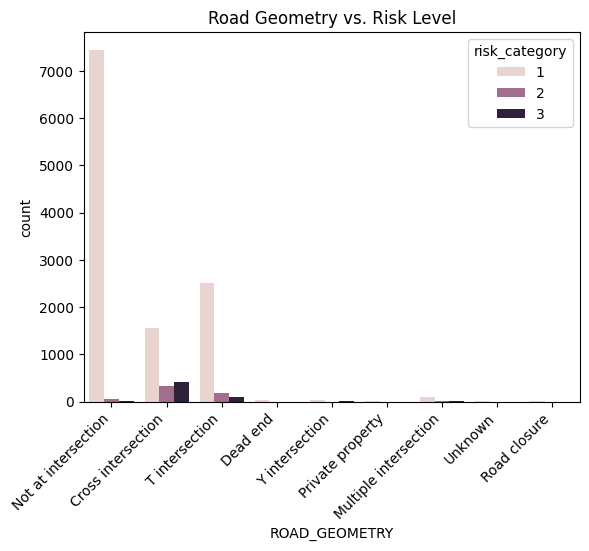

In [ ]:
sns.countplot(data=features_df, x='ROAD_GEOMETRY', hue='risk_category')
plt.title("Road Geometry vs. Risk Level")
plt.xticks(rotation=45, ha='right')
plt.show()


Most pedestrian crashes occur not at intersections, but higher-risk crashes (Risk Categories 2 and 3) are more concentrated at cross intersections and T-intersections. This suggests that intersections are significantly more dangerous for pedestrians, likely due to complex traffic movements and limited visibility.

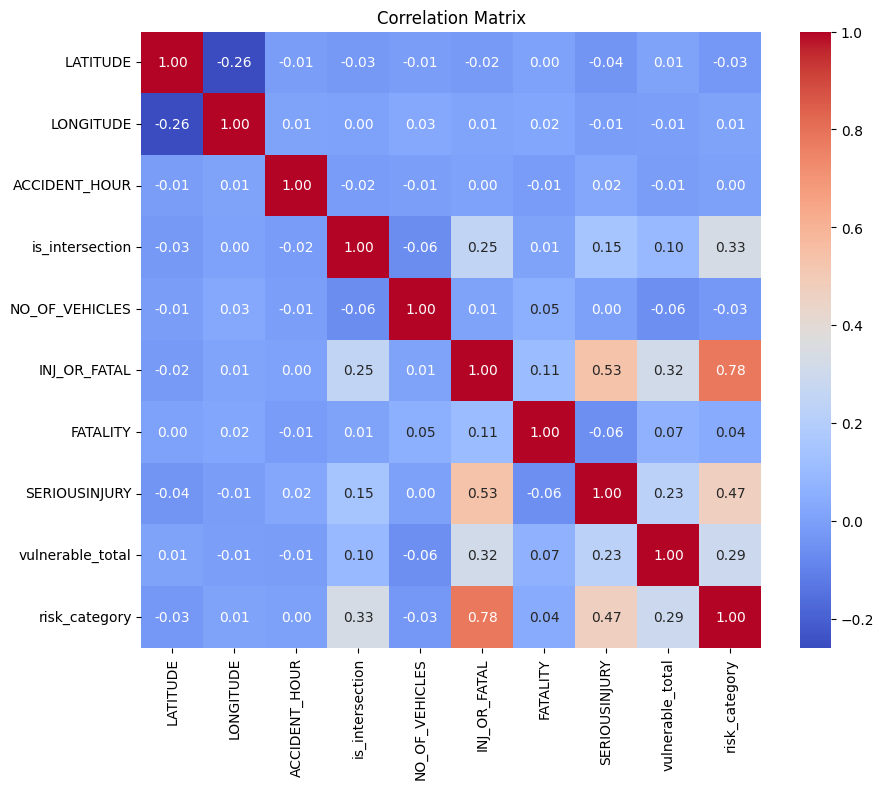

In [ ]:
corr = features_df.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


- risk_category has a strong positive correlation with INJ_OR_FATAL (0.78), and
moderate correlation with SERIOUSINJURY (0.47) and is_intersection (0.33).

- vulnerable_total also shows a moderate relationship (0.29), indicating higher risk in locations involving vulnerable groups.

- Features like LATITUDE, LONGITUDE, ACCIDENT_HOUR, and NO_OF_VEHICLES show little to no correlation with risk_category.

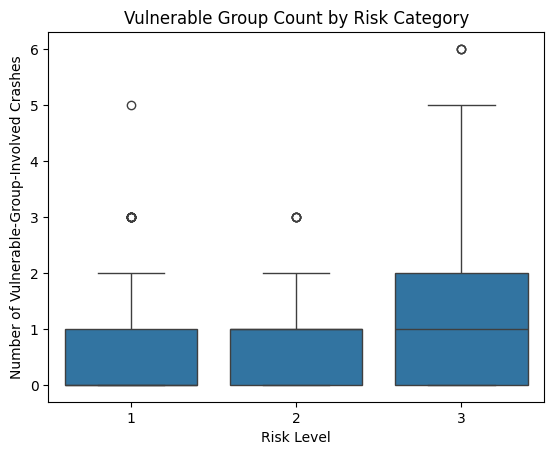

In [ ]:
sns.boxplot(data=features_df, x='risk_category', y='vulnerable_total')
plt.title("Vulnerable Group Count by Risk Category")
plt.xlabel("Risk Level")
plt.ylabel("Number of Vulnerable-Group-Involved Crashes")
plt.show()


Higher-risk locations (Risk Category 3) tend to involve more crashes with vulnerable groups (e.g., children, seniors).
While the median remains similar across categories, Risk Category 3 shows a wider spread and more extreme outliers, indicating that some high-risk locations have significantly more vulnerable-involved crashes.

This supports prioritizing high-risk areas not just by crash count, but also by equity and public health concerns — especially where vulnerable pedestrians are frequently affected.

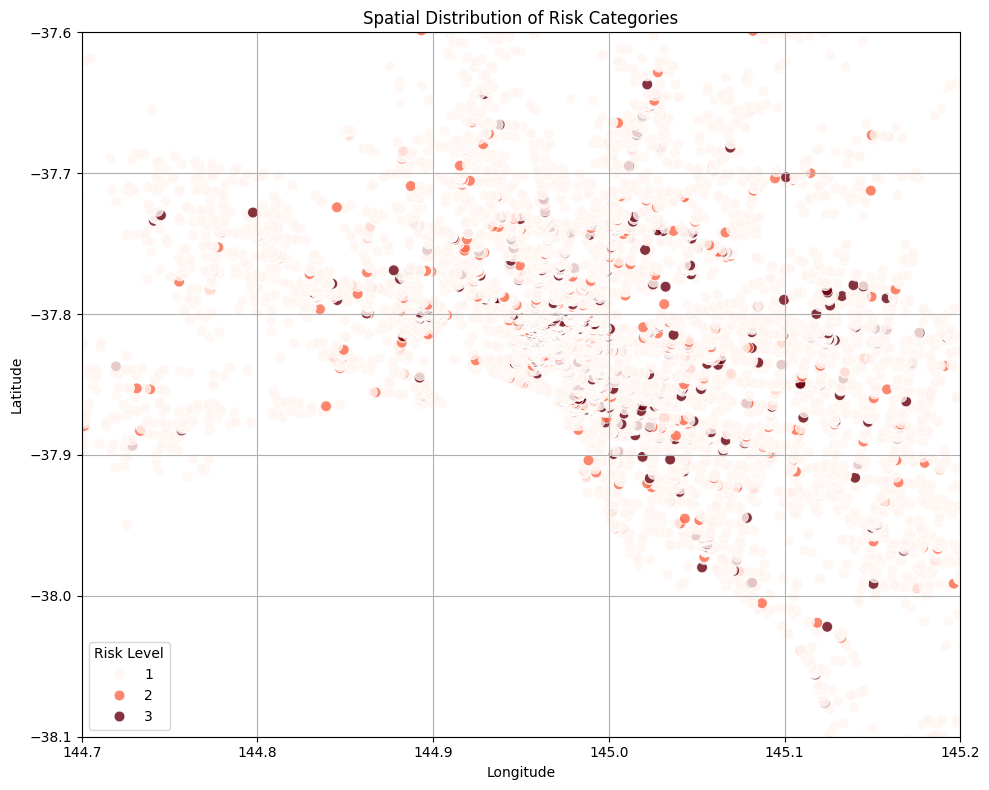

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot size
plt.figure(figsize=(10, 8))

# Create scatter plot with categorical hue
sns.scatterplot(
    data=features_df,
    x='LONGITUDE',
    y='LATITUDE',
    hue='risk_category',
    palette='Reds',   # You can also try 'Set1', 'Dark2', or custom color map
    alpha=0.8,        # Transparency
    s=60              # Marker size
)

# Titles and labels
plt.title("Spatial Distribution of Risk Categories")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Risk Level")

# Optional: zoom into Melbourne area
plt.xlim(144.7, 145.2)
plt.ylim(-38.1, -37.6)

# Layout adjustment
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


Pedestrian crash risk is densely concentrated in central Melbourne, particularly around the CBD and inner suburbs.
Higher-risk locations (Risk Category 3, shown in dark red) are clustered in high-traffic corridors and intersections, while lower-risk locations are more widely spread across the metro area.



In [ ]:
# Convert all boolean columns to 0/1
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)
y = features_df['risk_category']



## STEP 8: Feature selection


In [ ]:
import pandas as pd

# Combine X and y to compute correlation
combined_df = pd.concat([X, y], axis=1)

# Compute correlation with y
correlation_with_y = combined_df.corr()['risk_category'].sort_values(ascending=False)

# Show result
print(correlation_with_y)


risk_category                                 1.000000
INJ_OR_FATAL                                  0.780248
SERIOUSINJURY                                 0.472446
is_intersection                               0.334619
vulnerable_total                              0.288932
DTP_REGION_INNER METRO                        0.118692
LIGHT_CONDITION_Dark Street lights on         0.099061
SPEED_ZONE_60 km/hr                           0.088414
SPEED_ZONE_40 km/hr                           0.074523
DEG_URBAN_NAME_MELBOURNE_CBD                  0.069132
DEG_URBAN_NAME_MELB_URBAN                     0.063007
ROAD_GEOMETRY_Multiple intersection           0.062722
DAY_OF_WEEK_Monday                            0.042686
FATALITY                                      0.037159
LONGITUDE                                     0.011219
LIGHT_CONDITION_Dark Street lights off        0.009640
ROAD_GEOMETRY_T intersection                  0.007619
SPEED_ZONE_70 km/hr                           0.004399
DAY_OF_WEE

drop feature that have low correlation (<0.05) and 'SERIOUSINJURY', 'INJ_OR_FATAL', 'vulnerable_total' (unavailable pre-crash)

In [ ]:
X = X[[
    'is_intersection',
    'SPEED_ZONE_60 km/hr',
    'SPEED_ZONE_40 km/hr',
    'LIGHT_CONDITION_Dark Street lights on',
    'ROAD_GEOMETRY_Multiple intersection',
    'DEG_URBAN_NAME_MELBOURNE_CBD',
    'DEG_URBAN_NAME_MELB_URBAN',
    'DTP_REGION_INNER METRO'
]]
X

,is_intersection,SPEED_ZONE_60 km/hr,SPEED_ZONE_40 km/hr,LIGHT_CONDITION_Dark Street lights on,ROAD_GEOMETRY_Multiple intersection,DEG_URBAN_NAME_MELBOURNE_CBD,DEG_URBAN_NAME_MELB_URBAN,DTP_REGION_INNER METRO
0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
12861,0,0,0,0,0,0,0,0
12862,0,0,0,0,0,0,0,0
12863,0,0,0,1,0,0,0,0
12864,0,1,0,0,0,0,0,0


In [ ]:
X.describe()

,is_intersection,SPEED_ZONE_60 km/hr,SPEED_ZONE_40 km/hr,LIGHT_CONDITION_Dark Street lights on,ROAD_GEOMETRY_Multiple intersection,DEG_URBAN_NAME_MELBOURNE_CBD,DEG_URBAN_NAME_MELB_URBAN,DTP_REGION_INNER METRO
count,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000,12760.000000
mean,0.407367,0.310580,0.170219,0.213245,0.009169,0.028213,0.745063,0.543495
std,0.491363,0.462749,0.375840,0.409615,0.095320,0.165588,0.435843,0.498124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
from sklearn.preprocessing import StandardScaler

# Suppose you already have X_encoded and y
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)  # returns a NumPy array
X_scaled

array([[-0.82908642, -0.67118886, -0.45292151, ..., -0.17038855,
        -1.70954177, -1.09112691],
       [ 1.20614688, -0.67118886, -0.45292151, ..., -0.17038855,
        -1.70954177, -1.09112691],
       [-0.82908642, -0.67118886, -0.45292151, ..., -0.17038855,
        -1.70954177, -1.09112691],
       ...,
       [-0.82908642, -0.67118886, -0.45292151, ..., -0.17038855,
        -1.70954177, -1.09112691],
       [-0.82908642,  1.48989362, -0.45292151, ..., -0.17038855,
        -1.70954177, -1.09112691],
       [-0.82908642, -0.67118886, -0.45292151, ..., -0.17038855,
        -1.70954177, -1.09112691]])

In [ ]:
y.value_counts()

,count
risk_category,
1,11670
2,576
3,514


## STEP 9: Train/Test Split (for upcoming modeling)

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X_encoded and y are defined
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% test, 80% train
    random_state=42,     # For reproducibility
    stratify=y
)
